In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tqdm import tqdm
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from skimage.segmentation import felzenszwalb
from skimage.color import label2rgb
from rscube.nd_tools import (get_array_from_features, 
                             get_features_from_array, 
                             get_superpixel_area_as_features, 
                             get_superpixel_means_as_features,
                             get_superpixel_stds_as_features, 
                             scale_img)
from rscube.rio_tools import (get_geopandas_features_from_array, 
                              rasterize_shapes_to_array, 
                              get_indices_from_extent, get_cropped_profile)

from sklearn.cluster import KMeans
from skimage.segmentation import felzenszwalb
from skimage.color import label2rgb
from pprint import pprint
import geopandas as gpd
from rasterio import plot
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as score
import geopandas as gpd
from shapely.geometry import box
from rasterio.windows import Window

In [ ]:
SCENE_ID = 

In [3]:
df = gpd.read_file('chips.geojson')
df.head()

,CENTERX,CENTERY,STRATA,SAMPLE_ID,date,LS_Validat,random_id,geometry
0,-159.648125,69.21,3,3_38,2011-07-17,1,99,"POLYGON ((-159.89875 69.30000, -159.65900 69.3..."
1,-112.983750,67.05,4,4_27,2012-07-23,1,114,"POLYGON ((-113.21200 67.14000, -113.09850 67.1..."
2,17.698500,65.97,4,4_43,2010-07-24,1,20,"POLYGON ((17.61000 66.06000, 17.91700 66.06000..."
3,59.675000,65.79,3,3_1,2011-07-13,1,112,"POLYGON ((59.86900 65.88000, 59.89200 65.88000..."
4,-96.604375,62.73,4,4_34,2012-08-27,1,115,"POLYGON ((-96.79875 62.82000, -96.57700 62.820..."


In [4]:
with rasterio.open(f'test_chip/20211003_161639_91_241d_3B_AnalyticMS_SR_8b.tif') as ds:
    image_crs = ds.crs
    image_box = box(*ds.bounds)
    image_bounds = list(ds.bounds)
    image_profile = ds.profile
    image_shape = image_profile['height'], image_profile['width']

image_shape

(10003, 13622)

In [5]:
df_utm = df.to_crs(image_crs)
intersects = df_utm.geometry.intersects(image_box)
df_chip = df_utm[intersects].reset_index(drop=True)
df_chip.head()

,CENTERX,CENTERY,STRATA,SAMPLE_ID,date,LS_Validat,random_id,geometry
0,-95.866875,33.03,3,3_40,2011-07-10,1,42,"POLYGON ((222530.752 3668526.777, 241571.451 3..."


In [8]:
(start_y, start_x), (stop_y, stop_x) = get_indices_from_extent(image_profile['transform'],
                                                               list(df_chip.total_bounds),
                                                               shape=image_shape)
window = Window.from_slices((start_y, stop_y), (start_x, stop_x))
sx, sy = np.s_[start_x: stop_x], np.s_[start_y: stop_y]
profile_cropped = get_cropped_profile(image_profile, sx, sy)

In [10]:
index = df_chip.random_id[0]
index

42

In [11]:
with rasterio.open(f'test_chip/20211003_161639_91_241d_3B_AnalyticMS_SR_8b.tif') as ds:
    image_c = ds.read(window=window)
    image_c = image_c.transpose([1, 2, 0]).astype(np.float32)
image_c.shape

(6838, 6840, 8)

In [12]:
with rasterio.open(f'test_chip/20211003_161639_91_241d_3B_AnalyticMS_SR_8b.tif') as ds:

    t = ds.tags()
    d = ds.descriptions
    
list(enumerate(d))

[(0, 'coastal_blue'),
 (1, 'blue'),
 (2, 'green_i'),
 (3, 'green'),
 (4, 'yellow'),
 (5, 'red'),
 (6, 'rededge'),
 (7, 'nir')]

In [15]:
mask = (image_c[..., 0] == image_profile['nodata'])
image_c[mask, :] = np.nan

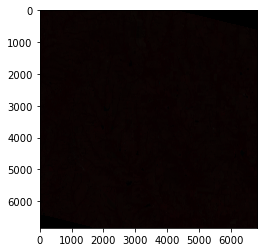

In [199]:
rgb = scale_img(image_c[..., [7, 5, 3]])
plt.imshow(rgb)

In [204]:
image = image_c[..., [7, 5, 3]]

image_view = image.copy()
for k in tqdm(range(3)):
    m0 = np.nanpercentile(image[~mask, k], 2)
    m1 = np.nanpercentile(image[~mask, k], 98)
    image_view[~mask, k] = np.clip(image[~mask, k], m0, m1)

100%|██████████| 3/3 [00:08<00:00,  2.73s/it]


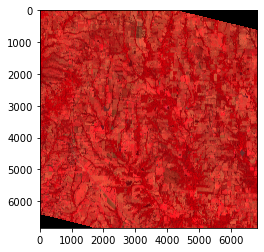

In [205]:
rgb = scale_img(image_view)
plt.imshow(rgb)

In [206]:
p = profile_cropped.copy()
p['count'] = 3
p['dtype'] = 'float32'
p['nodata'] = np.nan
with rasterio.open('test_cropped.tif', 'w', **p) as ds:
    ds.write(rgb.transpose([2, 0, 1]))

# Segmentation

In [207]:
image_seg = image.copy()
image_seg[mask, :] = -2000
segments_fz = felzenszwalb(image_seg, 
                           scale=1, 
                           sigma=0.0, 
                           min_size=10)

In [208]:
segments_fz += 1
segments_fz[mask] = 0

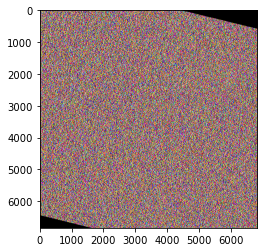

In [209]:
superpixel_labels_viz = label2rgb(segments_fz, bg_label=0)
plt.imshow(superpixel_labels_viz)

In [210]:
%%time

# features = get_geopandas_features_from_array(segments_fz.astype(np.int32), 
#                                              profile['transform'], 
#                                              label_name='label')

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 13.1 µs


In [211]:
%%time

# df_segments = gpd.GeoDataFrame.from_features(features)
# df_segments.head()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


In [212]:
%%time

# df_segments.crs = profile['crs']
# df_segments.to_file('segments.geojson', driver='GeoJSON')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


In [213]:
# %%time

# df_segments.crs = profile['crs']
# df_segments.to_file('segments')

# Generate Features

In [214]:
pixel_features = image.reshape((-1, image.shape[-1]))

In [215]:
superpixel_features_mean = get_superpixel_means_as_features(segments_fz, image)

In [216]:
superpixel_features_mean.shape

(1437745, 3)

In [217]:
superpixel_features_std = get_superpixel_stds_as_features(segments_fz, image)

/Users/cmarshak/opt/anaconda3/lib/python3.8/site-packages/scipy/ndimage/measurements.py:523: RuntimeWarning: invalid value encountered in true_divide
  means = sums / counts


In [218]:
superpixel_means = get_array_from_features(segments_fz, superpixel_features_mean)
superpixel_stds = get_array_from_features(segments_fz, superpixel_features_std)

In [219]:
superpixel_means_f = superpixel_means.reshape((-1, image.shape[-1]))
superpixel_stds_f = superpixel_stds.reshape((-1, image.shape[-1]))

In [246]:
all_features = np.hstack([pixel_features, 
                          superpixel_means_f, 
                          #superpixel_stds_f
                         ])
all_features.shape

(46771920, 6)

# Load Training data

<AxesSubplot:>

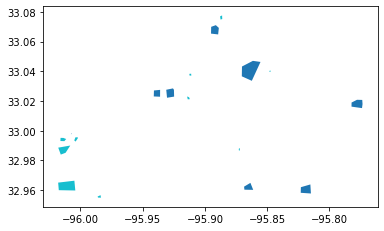

In [247]:
df = gpd.read_file(f'training_data_1')
df = df[~df.geometry.isna()].reset_index(drop=True)
df.plot(column='label_name')

In [248]:
df.head()

,label,label_name,geometry
0,1,water,"POLYGON ((-96.01781 32.98859, -96.00814 32.990..."
1,1,water,"POLYGON ((-96.00814 32.99772, -96.00802 32.997..."
2,1,not_water,"POLYGON ((-96.00741 32.99805, -96.00693 32.998..."
3,1,water,"POLYGON ((-96.01787 32.96505, -96.00485 32.966..."
4,1,water,"POLYGON ((-96.00494 32.99347, -96.00398 32.995..."


In [249]:
labels = rasterize_shapes_to_array(df.to_crs(profile_cropped['crs']).geometry, 
                                   df.label + 1, 
                                   profile_cropped, 
                                   all_touched=False)

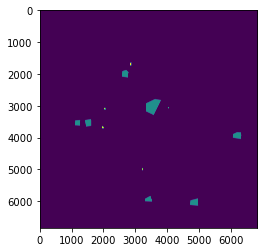

In [250]:
plt.imshow(labels)

In [251]:
labels_f = labels.reshape((-1, 1)).ravel()

f_mask = ~(labels_f == 0).ravel()

In [252]:
X_labeled = all_features[f_mask]
y_labeled = labels_f[f_mask]

In [253]:
X_train, X_test, y_train, y_test = train_test_split(X_labeled, 
                                                    y_labeled, 
                                                    test_size=0.1, 
                                                    random_state=0)

In [254]:
rf = RandomForestClassifier(n_estimators=500,
                            oob_score=True,
                            random_state=0,
                            n_jobs=8)

In [255]:
%%time

rf.fit(X_train, 
       y_train)


CPU times: user 2min 4s, sys: 672 ms, total: 2min 5s
Wall time: 23 s


RandomForestClassifier(n_estimators=500, n_jobs=8, oob_score=True,
                       random_state=0)

In [256]:
y_pred = rf.predict(X_test)


In [257]:
class_dict = {1: 'not_water', 
              2: 'water'}

In [258]:
y_pred_str = pd.Series([class_dict[class_id] for class_id in y_pred], name='Predicted')
y_true_str = pd.Series([class_dict[class_id] for class_id in y_test], name='True')

In [259]:
df = pd.crosstab(y_true_str, y_pred_str)
df

Predicted,not_water,water
True,,
not_water,35960,0
water,0,1067


In [260]:
all_mask_f = (mask.reshape((-1,)))

X_all = all_features[~all_mask_f, 
                     ...]

In [261]:
y_all = rf.predict(X_all)

In [262]:
y_arr = np.zeros(mask.shape)

y_arr[~mask] = y_all
y_arr[mask] = np.nan

In [263]:
p = profile_cropped.copy()
p['count'] = 1 
with rasterio.open(f'class_out_{index}.tif', 'w', **p) as ds:
    ds.write(y_arr, 1)

In [ ]:
plt.imshow(y_arr, interpolation='none')

# Manual Items Again

In [265]:
max_segment = np.nanmax(segments_fz)

encoded_class_segments = segments_fz + max_segment * y_arr
encoded_class_segments[mask] = 0

In [266]:
seg_feature_class = get_geopandas_features_from_array(encoded_class_segments.astype(np.int32), 
                                                      profile_cropped['transform'], 
                                                      label_name='encoded_label')


KeyboardInterrupt: 

In [ ]:
df_for_analysis = gpd.GeoDataFrame.from_features(seg_feature_class)

In [ ]:
df_for_analysis['max_segment'] = max_segment
df_for_analysis['segment_label'] = df_for_analysis['encoded_label'] % df_for_analysis['max_segment']
df_for_analysis['class_label'] = df_for_analysis['encoded_label'] // df_for_analysis['max_segment']

df_for_analysis.head()

In [ ]:
from rasterio.crs import CRS
df_for_analysis.crs = profile_cropped['crs']


In [ ]:
df_for_analysis.info(memory_usage="deep")

In [ ]:
df_for_analysis.to_file('analysis_labels')